In [1]:
# 코랩에 나눔고딕 폰트 설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (8,159 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122545 files and di

- 플롯에 한글 폰트를 적용하기 위해 나눔고딕을 설치한 후, 런타임을 다시 시작해야 하므로 런타임 종료 코드를 실행한다.

In [ ]:
import os
os.kill(os.getpid(), 9) # 런타임 종료

In [1]:
# 일단 import 
import glob
import pandas as pd

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

import seaborn as sns 

# https://rfriend.tistory.com/346
# 경고 메시지 숨기기 (ignore warning message)
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
plt.rc('font', family='NanumBarunGothic') 

In [3]:
# 데이터 준비
import numpy as np

data = np.random.randint(-200, 100, 50).cumsum()
data

array([  -76,  -107,   -10,   -69,   -13,  -136,  -166,  -128,  -120,
         -66,  -232,  -173,  -327,  -320,  -518,  -460,  -434,  -466,
        -617,  -796,  -980,  -965, -1060, -1185, -1218, -1234, -1290,
       -1210, -1407, -1447, -1433, -1565, -1730, -1674, -1719, -1905,
       -1867, -1772, -1728, -1925, -2072, -2002, -2168, -2284, -2216,
       -2160, -2263, -2312, -2499, -2604])

Text(0.5, 0, '시간(분)')

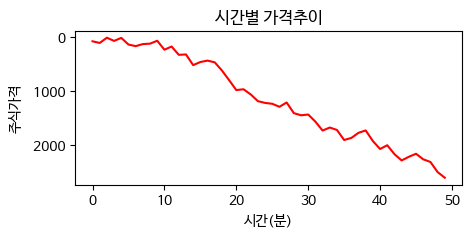

In [4]:
# 한글을 넣어놓고 그러보면 깨진다
plt.figure(figsize=(5,2))
plt.plot(range(50), data, 'r')
plt.title('시간별 가격추이')
plt.ylabel('주식가격')
plt.xlabel('시간(분)')

In [5]:
# 구글 드라이브 마운트하기.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 데이터 로드

## 서울시 상권분석서비스(상권영역) 로드 : 2021년 12월 기준
- 데이터 출처: [서울시 상권분석서비스(상권영역)](https://data.seoul.go.kr/dataList/OA-15560/S/1/datasetView.do)

In [6]:
df_sanggwon = pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/상권/서울시 상권분석서비스(상권영역).csv',
                        encoding='cp949')
display(df_sanggwon.shape, df_sanggwon.head())

(1671, 10)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,11545710,NaN
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,11350611,NaN
2,202112,A,골목상권,2110755,동일여자고등학교,192300,439070,11545,11545680,NaN
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289,438014,11545,11545690,NaN
4,202112,A,골목상권,2111017,송파나루역 3번,210222,445516,11710,11710562,NaN


In [7]:
df_sanggwon['기준_년월_코드'].value_counts()

202112    1671
Name: 기준_년월_코드, dtype: int64

### x, y 좌표값으로 위,경도 데이터 뽑기

In [8]:
# !pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.7 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import pyproj
import folium

In [10]:
# 좌표정보만 불러오기로 한다.

df_test = df_sanggwon[['엑스좌표_값', '와이좌표_값']]
display(df_test.dtypes, df_test.tail())

엑스좌표_값    int64
와이좌표_값    int64
dtype: object

,엑스좌표_값,와이좌표_값
1666,200974,451975
1667,199768,452273
1668,210191,446339
1669,205310,445727
1670,199503,448326


In [11]:
# 우선 좌표계를 변환해주는 함수를 다음과 같이 정의한다.

def project_array(coord, p1_type, p2_type):
    """
    좌표계 변환 함수
    - coord: x, y 좌표 정보가 담긴 NumPy Array
    - p1_type: 입력 좌표계 정보 ex) epsg:5179
    - p2_type: 출력 좌표계 정보 ex) epsg:4326
    """
    p1 = pyproj.Proj(init=p1_type)
    p2 = pyproj.Proj(init=p2_type)
    fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
    return np.dstack([fx, fy])[0]

In [12]:
# 좌표계 정보가 담긴 DataFrame 객체를 NumPy Array 객체로 만들고, 
# 이 값을 위에서 정의한 함수에 다음과 같이 적용

# DataFrame -> NumPy Array 변환
coord = np.array(df_test)
coord

array([[191934, 438813],
       [206265, 459431],
       [192300, 439070],
       ...,
       [210191, 446339],
       [205310, 445727],
       [199503, 448326]])

In [13]:
# 좌표계 정보 설정
p1_type = "epsg:5181"
p2_type = "epsg:4326"

# project_array() 함수 실행
result = project_array(coord, p1_type, p2_type)
result

array([[126.90884426,  37.44868725],
       [127.07097812,  37.63446919],
       [126.91297783,  37.45100597],
       ...,
       [127.11527495,  37.51647607],
       [127.0600594 ,  37.51100291],
       [126.99437686,  37.53443511]])

In [14]:
# 이제 경도 위도 좌표계로 변환된 NumPy Array를 DataFrame에 추가
df_test['경도'] = result[:, 0]
df_test['위도'] = result[:, 1]

In [15]:
# 상권영역 데이터 기준으로 merge
df_sang_total = pd.merge(df_sanggwon, df_test, on=['엑스좌표_값', '와이좌표_값'])
display(df_sang_total.shape, df_sang_total.head(2))

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,경도,위도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,11545710,NaN,126.908844,37.448687
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,11350611,NaN,127.070978,37.634469


### `행정동 코드` 컬럼값 변경

In [16]:
df_sang_total['행정동_코드'] = df_sang_total['행정동_코드'] % 1000
display(df_sang_total.shape, df_sang_total.head())

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,경도,위도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,710,NaN,126.908844,37.448687
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,611,NaN,127.070978,37.634469
2,202112,A,골목상권,2110755,동일여자고등학교,192300,439070,11545,680,NaN,126.912978,37.451006
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289,438014,11545,690,NaN,126.901564,37.441482
4,202112,A,골목상권,2111017,송파나루역 3번,210222,445516,11710,562,NaN,127.115614,37.509060


In [17]:
df_sang_total.columns

Index(['기준_년월_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '엑스좌표_값',
       '와이좌표_값', '시군구_코드', '행정동_코드', '형태정보', '경도', '위도'],
      dtype='object')

In [18]:
# 활용할 컬럼만 추출
df_sang_final = df_sang_total[['기준_년월_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '시군구_코드', '행정동_코드', '위도', '경도']]
df_sang_final.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시군구_코드,행정동_코드,위도,경도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,11545,710,37.448687,126.908844
1,202112,A,골목상권,2110427,노원 을지대학교병원,11350,611,37.634469,127.070978
2,202112,A,골목상권,2110755,동일여자고등학교,11545,680,37.451006,126.912978
3,202112,A,골목상권,2110739,시흥3동 우편취급국,11545,690,37.441482,126.901564
4,202112,A,골목상권,2111017,송파나루역 3번,11710,562,37.509060,127.115614


### 자치구 코드 정보 붙이기
- 데이터 출처: [행정구역 코드정보](https://data.seoul.go.kr/dataVisual/seoul/seoulLivingPopulation.do)

In [19]:
dong_code = pd.read_excel('/content/gdrive/MyDrive/ecothonCBB/data/상권/행정동코드_매핑정보_20200325.xlsx')

display(dong_code.shape, dong_code.head(2))

(425, 5)

,통계청행정동코드,행자부행정동코드,시도명,시군구명,행정동명
0,H_SDNG_CD,H_DNG_CD,DO_NM,CT_NM,H_DNG_NM
1,1101053,11110530,서울,종로구,사직동


In [20]:
## 자치구코드 컬럼 만들기
dong_code['자치구코드'] = dong_code['행자부행정동코드'].str.slice(start=0, stop=5)

## 행정동코드 컬럼 만들기
dong_code['행정동코드'] = dong_code['행자부행정동코드'].str.slice(start=-3)

dong_code.head()

,통계청행정동코드,행자부행정동코드,시도명,시군구명,행정동명,자치구코드,행정동코드
0,H_SDNG_CD,H_DNG_CD,DO_NM,CT_NM,H_DNG_NM,H_DNG,_CD
1,1101053,11110530,서울,종로구,사직동,11110,530
2,1101054,11110540,서울,종로구,삼청동,11110,540
3,1101055,11110550,서울,종로구,부암동,11110,550
4,1101056,11110560,서울,종로구,평창동,11110,560


In [21]:
# 첫 행 삭제 후, '자치구코드' 컬럼만 추출
dong_code = dong_code.drop([0], axis = 0)
dong_code_gu = dong_code[['시도명', '시군구명', '자치구코드', '행정동명', '행정동코드']]
dong_code_gu

,시도명,시군구명,자치구코드,행정동명,행정동코드
1,서울,종로구,11110,사직동,530
2,서울,종로구,11110,삼청동,540
3,서울,종로구,11110,부암동,550
4,서울,종로구,11110,평창동,560
5,서울,종로구,11110,무악동,570
...,...,...,...,...,...
420,서울,강동구,11740,둔촌1동,690
421,서울,강동구,11740,둔촌2동,700
422,서울,강동구,11740,암사1동,570
423,서울,강동구,11740,천호2동,610


In [22]:
# 중복행 제거
dong_code_gu = dong_code_gu.drop_duplicates(ignore_index=True)
dong_code_gu

,시도명,시군구명,자치구코드,행정동명,행정동코드
0,서울,종로구,11110,사직동,530
1,서울,종로구,11110,삼청동,540
2,서울,종로구,11110,부암동,550
3,서울,종로구,11110,평창동,560
4,서울,종로구,11110,무악동,570
...,...,...,...,...,...
419,서울,강동구,11740,둔촌1동,690
420,서울,강동구,11740,둔촌2동,700
421,서울,강동구,11740,암사1동,570
422,서울,강동구,11740,천호2동,610


In [23]:
# '자치구코드'와 '행정동코드' 모두 object 형에서 int 형으로 변환
dong_code_gu_dong = dong_code_gu.astype({'자치구코드':'int', '행정동코드':'int'})
print(dong_code_gu_dong.dtypes)

시도명      object
시군구명     object
자치구코드     int64
행정동명     object
행정동코드     int64
dtype: object


In [28]:
# 데이터셋 merge 하기
df_sang_code = pd.merge(df_sang_final, dong_code_gu_dong, how='left', 
                        left_on=['시군구_코드','행정동_코드'], 
                        right_on=['자치구코드', '행정동코드'])

# 데이터 확인
df_sang_code.head(2)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시군구_코드,행정동_코드,위도,경도,시도명,시군구명,자치구코드,행정동명,행정동코드
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,11545,710,37.448687,126.908844,서울,금천구,11545,시흥5동,710
1,202112,A,골목상권,2110427,노원 을지대학교병원,11350,611,37.634469,127.070978,서울,노원구,11350,하계1동,611


In [29]:
df_sang_fin = df_sang_code[['기준_년월_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '시도명', '시군구_코드',
       '시군구명', '행정동_코드', '행정동명','위도', '경도']]
display(df_sang_fin.shape, df_sang_fin.head(2))

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,서울,11545,금천구,710,시흥5동,37.448687,126.908844
1,202112,A,골목상권,2110427,노원 을지대학교병원,서울,11350,노원구,611,하계1동,37.634469,127.070978


### 서울시 상권분석서비스(상권-생활인구) 정보 붙이기 : 2017~2022년 
- 데이터 출처: [서울시 상권분석서비스(상권-생활인구)](https://data.seoul.go.kr/dataList/OA-15568/S/1/datasetView.do)

In [30]:
df_population = pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울시_인구/서울시 상권분석서비스(상권-생활인구).csv',
                        encoding='cp949')
display(df_population.shape, df_population.head(2))

(40041, 532)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,55901,56757,8418,...,185,181,158,46,66,115,162,158,132,39
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,1757144,1875581,420460,...,6788,6949,8331,4315,7017,6913,6385,6565,7523,4113


In [31]:
df_population['기준 년코드'].value_counts(sort=False)

# 데이터가 2017~2022년까지 있다는 것을 확인!

2022    6674
2021    6672
2020    6674
2019    6676
2018    6673
2017    6672
Name: 기준 년코드, dtype: int64

#### 2022년 데이터만 가져오기 

In [32]:
df_population_2022 = df_population[df_population['기준 년코드'] == 2022]
display(df_population_2022.shape, df_population_2022.head(2))

(6674, 532)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,55901,56757,8418,...,185,181,158,46,66,115,162,158,132,39
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,1757144,1875581,420460,...,6788,6949,8331,4315,7017,6913,6385,6565,7523,4113


In [33]:
# 사용할 컬럼만 추출
df_population_2022 = df_population_2022[['기준 년코드', '기준_분기_코드', '상권_구분_코드', ' 상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '총_생활인구_수']]
df_population_2022.head(2)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727


In [34]:
# 선택하여 열 이름 변경하기
df_population_2022 = df_population_2022.rename(columns={' 상권_구분_코드_명': '상권_구분_코드_명'})

## 상권영역(df_sang_fin)과 생활인구(df_population_2022) merge
- 상권영역(df_sang_fin): 2021년 12월 기준
- 생활인구(df_population_2022): 2022년 기준

In [37]:
# 상권영역(df_sang_fin): 2021년 12월 기준
display(df_sang_fin.shape, df_sang_fin.head(2))

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,서울,11545,금천구,710,시흥5동,37.448687,126.908844
1,202112,A,골목상권,2110427,노원 을지대학교병원,서울,11350,노원구,611,하계1동,37.634469,127.070978


In [38]:
# 생활인구(df_population_2022): 2022년 기준
display(df_population_2022.shape, df_population_2022.head(2))

(6674, 7)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727


In [39]:
# 생활인구(df_population_2022) 기준으로 상권영역(df_sang_fin) 과 merge
df_sang_pop = pd.merge(df_population_2022, df_sang_fin, 
                             on=['상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명'])
display(df_sang_pop.shape, df_sang_pop.head(2))

(6674, 15)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,기준_년월_코드,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,202112,서울,11680,강남구,580,삼성1동,37.511003,127.060059
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,112779,202112,서울,11680,강남구,580,삼성1동,37.511003,127.060059


In [41]:
# 사용할 컬럼만 추출
df_sang_pop_fin = df_sang_pop[['기준 년코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '총_생활인구_수', '시도명', '시군구_코드', '시군구명', '행정동_코드', '행정동명', '위도', '경도']]
display(df_sang_pop_fin.shape, df_sang_pop_fin.head(2))

(6674, 14)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,서울,11680,강남구,580,삼성1동,37.511003,127.060059
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,112779,서울,11680,강남구,580,삼성1동,37.511003,127.060059


### csv 파일로 저장

In [42]:
df_sang_pop_fin.to_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울상권_인구_위경도(수정).csv', index=False)

In [43]:
pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울상권_인구_위경도(수정).csv')

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,서울,11680,강남구,580,삼성1동,37.511003,127.060059
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,112779,서울,11680,강남구,580,삼성1동,37.511003,127.060059
2,2022,2,U,관광특구,1001496,강남 마이스 관광특구,106859,서울,11680,강남구,580,삼성1동,37.511003,127.060059
3,2022,1,U,관광특구,1001496,강남 마이스 관광특구,92815,서울,11680,강남구,580,삼성1동,37.511003,127.060059
4,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,서울,11710,송파구,566,오륜동,37.516476,127.115275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,2022,1,A,골목상권,2110002,독립문역 1번,302828,서울,11110,종로구,570,무악동,37.575540,126.957209
6670,2022,4,A,골목상권,2110001,이북5도청사,179890,서울,11110,종로구,560,평창동,37.609345,126.956884
6671,2022,3,A,골목상권,2110001,이북5도청사,167429,서울,11110,종로구,560,평창동,37.609345,126.956884
6672,2022,2,A,골목상권,2110001,이북5도청사,145911,서울,11110,종로구,560,평창동,37.609345,126.956884
